(60000, 784)
(10000, 784)
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s - loss: 0.3441 - val_loss: 0.2641
Epoch 2/100
60000/60000 [==============================] - 1s - loss: 0.2590 - val_loss: 0.2532
Epoch 3/100
60000/60000 [==============================] - 1s - loss: 0.2451 - val_loss: 0.2349
Epoch 4/100
60000/60000 [==============================] - 1s - loss: 0.2262 - val_loss: 0.2162
Epoch 5/100
60000/60000 [==============================] - 1s - loss: 0.2105 - val_loss: 0.2016
Epoch 6/100
60000/60000 [==============================] - 1s - loss: 0.1938 - val_loss: 0.1856
Epoch 7/100
60000/60000 [==============================] - 1s - loss: 0.1834 - val_loss: 0.1789
Epoch 8/100
60000/60000 [==============================] - 1s - loss: 0.1766 - val_loss: 0.1715
Epoch 9/100
60000/60000 [==============================] - 1s - loss: 0.1717 - val_loss: 0.1673
Epoch 10/100
60000/60000 [==============================] - 

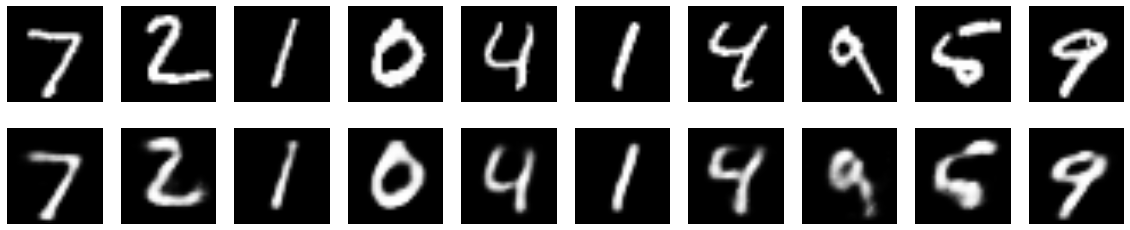

In [5]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer1 = autoencoder.layers[-3]
decoder_layer2 = autoencoder.layers[-2]
decoder_layer3 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))

# Now let's train our autoencoder to reconstruct MNIST digits.
# First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# Prepare input data. We're using MNIST digits, and we're discarding the labels (we're only interested in encoding/decoding the input images).

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

# We will normalize all values between 0 and 1 and we will flatten the 28x28 images into vectors of size 784.

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

# Now let's train our autoencoder for 50 epochs:

autoencoder.fit(x_train, x_train,
                nb_epoch=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))
                
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# use Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()